In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk
from datetime import date




url="https://uzmanpara.milliyet.com.tr/canli-borsa/bist-TUM-hisseleri/"
r=requests.get(url)
soup=BeautifulSoup(r.content,"html.parser")

bs=BeautifulSoup(r.content, "lxml")
data=soup.find("div",{"class":"box box10 last"})



In [8]:
data=soup.find("tr",{"id":"h_tr_id_KCHOL"})


In [9]:
data=soup.find("td",{"id":"h_td_fiyat_id_KCHOL"})
text=data.text

In [10]:
text=text.replace(',', '.')
text=float(text)
text

99.4

In [11]:
kchol=pd.read_csv("/Users/Bora/Documents/GitHub/Borsa-Hisse-Analizi/kchol.csv")
kchol.index=pd.to_datetime(kchol["Date"])


In [3]:
del kchol["Date"]

In [4]:
kchol=pd.DataFrame(kchol)

In [5]:
kchol

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,20.08,20.00,20.36,19.93,10.53M,0.40%
2021-01-05,20.02,19.89,20.46,19.76,15.65M,-0.30%
2021-01-06,20.02,20.12,20.21,19.76,12.23M,0.00%
2021-01-07,19.98,20.08,20.14,19.78,7.91M,-0.20%
2021-01-08,20.38,20.10,20.38,20.00,10.36M,2.00%
...,...,...,...,...,...,...
2023-06-12,101.00,104.60,105.50,101.00,22.71M,-2.51%
2023-06-13,99.60,100.60,102.50,97.70,30.46M,-1.39%
2023-06-14,99.30,99.95,103.60,98.30,32.30M,-0.30%


In [6]:
close=pd.DataFrame(kchol["Price"])

close


,Price
Date,
2021-01-04,20.08
2021-01-05,20.02
2021-01-06,20.02
2021-01-07,19.98
2021-01-08,20.38
...,...
2023-06-12,101.00
2023-06-13,99.60
2023-06-14,99.30


In [12]:
dict={'Date':date.today(),'Price':text}
df=pd.DataFrame.from_dict(dict,orient="index")
df=df.T
df.reset_index()
df

,Date,Price
0,2023-06-18,99.4


In [13]:
df.set_index=df["Date"]
df

,Date,Price
0,2023-06-18,99.4


In [14]:
df.index=df["Date"]

In [15]:
del df["Date"]

In [16]:
df.index=pd.to_datetime(df.index)
df

,Price
Date,
2023-06-18,99.4


In [15]:
close=pd.concat([close,df])
close

,Price
Date,
2021-01-04,20.08
2021-01-05,20.02
2021-01-06,20.02
2021-01-07,19.98
2021-01-08,20.38
...,...
2023-06-13,99.6
2023-06-14,99.3
2023-06-15,101.0


In [17]:
rolling_app5=close.rolling(window=10).mean()
rolling_app14=close.rolling(window=25).mean()
rolling_app21=close.rolling(window=45).mean()



In [18]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [19]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-03-05,21.86,21.491,21.0328,20.761778
2021-03-08,21.37,21.436,21.1132,20.790444
2021-03-09,22.03,21.510,21.2140,20.835111
2021-03-10,22.20,21.631,21.2896,20.883556
2021-03-11,22.12,21.703,21.3576,20.931111
...,...,...,...,...
2023-06-12,101.00,91.825,85.6180,82.452222
2023-06-13,99.60,93.670,86.3780,82.932222
2023-06-14,99.30,95.720,86.8760,83.415556


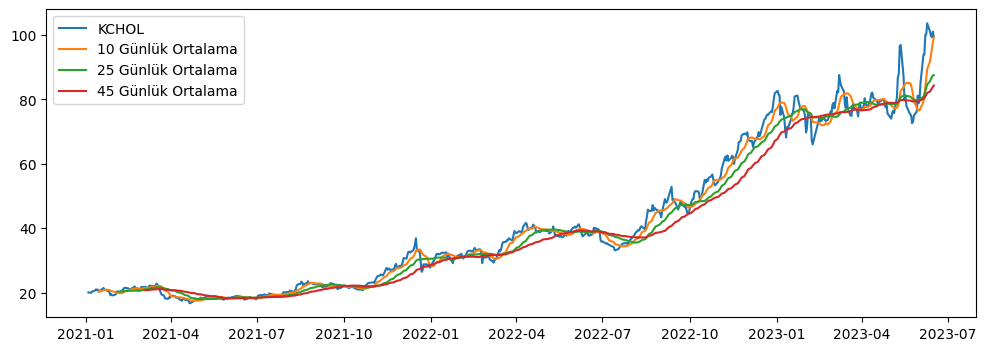

In [20]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='KCHOL')
ax.plot(rolling_app5.index,rolling_app5,label='10 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='25 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='45 Günlük Ortalama')
ax.legend(loc='upper left')


In [68]:
def buy_sell(data,perc=25):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [69]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

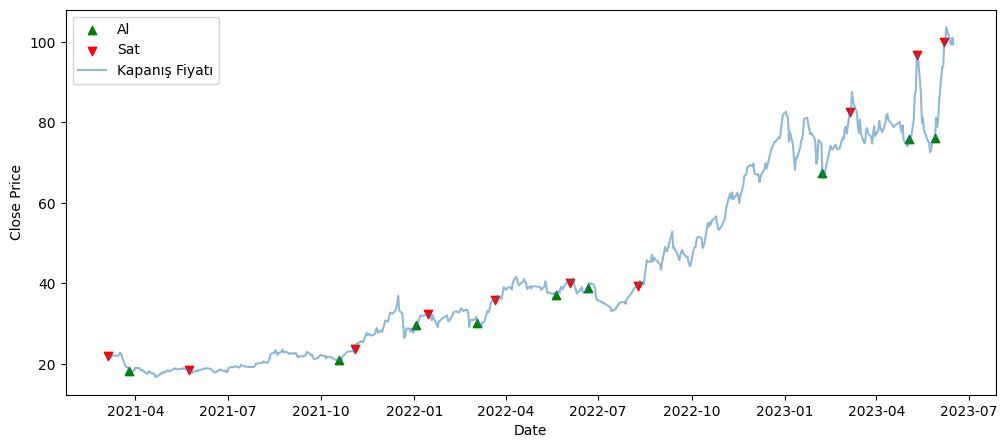

In [70]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [71]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-03-26    18.23
2021-10-19    21.03
2022-01-03    29.59
2022-03-04    30.28
2022-05-20    37.22
2022-06-21    38.93
2023-02-07    67.43
2023-05-03    75.75
2023-05-29    76.20
Name: Al, dtype: float64

In [81]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-03-05     21.86
2021-05-24     18.54
2021-11-03     23.81
2022-01-14     32.37
2022-03-21     35.78
2022-06-03     40.18
2022-08-09     39.30
2023-03-06     82.64
2023-05-11     96.60
2023-06-07    100.00
Name: Sat, dtype: float64

In [82]:
del sat["2021-03-05"]

In [83]:
sat_val=sat.values
al_val=al.values


In [84]:
sat_val1=sat_val

In [85]:
sat_val1

array([ 18.54,  23.81,  32.37,  35.78,  40.18,  39.3 ,  82.64,  96.6 ,
       100.  ])

In [86]:
al_val1=al_val
al_val1

array([18.23, 21.03, 29.59, 30.28, 37.22, 38.93, 67.43, 75.75, 76.2 ])

In [100]:
res=[]

for i in range(9):
    res.append((sat_val1[i]/al_val1[i]))

In [88]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.017005
1,1.132192
2,1.093951
3,1.181638
4,1.079527
5,1.009504
6,1.225567
7,1.275248
8,1.312336


In [89]:
res0=[100]
for i in range(9):
    res0.append(res0[i]*df["Kar"].loc[i])


In [90]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,1.017005,101.700494
1,1.132192,115.144496
2,1.093951,125.962397
3,1.181638,148.841961
4,1.079527,160.678936
5,1.009504,162.206067
6,1.225567,198.794444
7,1.275248,253.512123
8,1.312336,332.693075


In [91]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 232.69307453805516


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [92]:
sat_val2=sat_val[1:8:2]

In [93]:
sat_val2

array([23.81, 35.78, 39.3 , 96.6 ])

In [94]:
al_val2=al_val[0:8:2]
al_val2

array([18.23, 29.59, 37.22, 67.43])

In [95]:
res1=[]

for i in range(4):
    res1.append((sat_val2[i]/al_val2[i]))

In [96]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.306089
1,1.209192
2,1.055884
3,1.432597


In [97]:
res2=[100]
for i in range(4):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [98]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.306089,130.608886
1,1.209192,157.931259
2,1.055884,166.757079
3,1.432597,238.895652


In [99]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 138.89565236202603
